In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
from math import sqrt,cos,acos,pi,exp,sin,atan2,log
from numpy import arange,mean,asarray,isnan,isinf
import pickle
from scipy import stats
import random
from matplotlib.colors import LogNorm

import csv
import sys
import pandas as pd
import os

lowEpatch = False#True if fset in [0,5,8,9] else False
vtxCut    = 5
cutMode = 0

C1_POT = 1.558e+20 + 1.129e+17 + 1.869e+19
D2_POT = 1.63e+20 + 2.964e+19 + 1.239e+19
E1_POT = 5.923e+19
F1_POT = 4.3e+19
G1_POT = 1.701e+20 + 2.97e+19 + 1.524e+17

DAT_POT1 = C1_POT
DAT_POT2 = E1_POT+D2_POT
DAT_POT3 = F1_POT+G1_POT
    
DATA_POT_TOT = DAT_POT1 + DAT_POT2 + DAT_POT3

def poisson_errors(k, CL = 0.6827): 
    
    # 1 Sig = 0.6827
    # 2 Sig = 0.9545
    # 3 Sig = 0.9973
    
    a = 1.0 - CL
    low, high = (stats.chi2.ppf(a/2, 2*k) / 2, stats.chi2.ppf(1-a/2, 2*k + 2) / 2)
    low = np.where(k==0,0,low)
    return k - low, high - k


In [2]:
tag='3March2021_vA_fullLowE_withPi0Sample_newShowerCalib'

filetaglist = {1:['data','ext','overlay','overlay_lowE','intrinsics','intrinsics_lowE','ncpi0','ccpi0'],
               2:['overlay','overlay_lowE','intrinsics','intrinsics_lowE'],
               3:['data','ext','overlay','overlay_lowE','intrinsics','intrinsics_lowE','ncpi0','ccpi0']}

df = {1:{},2:{},3:{}}
df_swap = {1:{},2:{},3:{}}

psavedir = 'Parquets/'+tag+'/'

for r in [1,2,3]:
    print('\n\n','#'*20,'RUN',r,'#'*20,'\n')

    for filetag in filetaglist[r]:
        if 'lowE' in filetag: continue
        print('Sample:',filetag)
        if filetag=='data':
            pstring = 'SelectionMode%i_%s_run%i_r23swap.parquet.gzip'%(cutMode,filetag,r)
        else:
            pstring = 'SelectionMode%i_%s_run%i_r23swap.parquet.gzip'%(cutMode,filetag,r)
        try:
            df_swap[r][filetag] = pd.read_parquet(psavedir+pstring)
            print(len(df_swap[r][filetag]))
        except:
            pass
        
        if filetag=='data':
            pstring = 'SelectionMode%i_%s_run%i.parquet.gzip'%(cutMode,filetag,r)
        else:
            pstring = 'SelectionMode%i_%s_run%i.parquet.gzip'%(cutMode,filetag,r)
        try:
            df[r][filetag] = pd.read_parquet(psavedir+pstring)
            print(len(df[r][filetag]))
        except:
            pass



 #################### RUN 1 #################### 

Sample: data
367
Sample: ext
263
263
Sample: overlay
5602
5602
Sample: intrinsics
14733
14733
Sample: ncpi0
589
589
Sample: ccpi0
285
285


 #################### RUN 2 #################### 

Sample: overlay
5784
5784
Sample: intrinsics
11241
11241


 #################### RUN 3 #################### 

Sample: data
72
Sample: ext
537
537
Sample: overlay
3943
3943
Sample: intrinsics
5940
5940
Sample: ncpi0
504
504
Sample: ccpi0
266
266


In [3]:
# HELPER FUNCTIONS

def MakeBDTcut(idf,sigcut,mode,nBDTs,r2overlay=False,ttc=0.1,nDrop=0):
    
    # Conglemerate BDT scores and weights based on strategy 
    
    bdtweight = np.zeros(idf.shape[0])
    sigprobmax = np.zeros(idf.shape[0]) 
    sigprobavg = np.zeros(idf.shape[0])
    sigprobmedian = np.zeros(idf.shape[0])
    sigproblist = np.zeros((idf.shape[0],nBDTs))
    notintrain = np.zeros((idf.shape[0],nBDTs),dtype=bool)
    numnottrain = np.zeros(idf.shape[0])
    
    mask = random.sample(range(nBDTs),nDrop)
    
    for b in range(nBDTs):
        sp = idf['sigprob%i'%b]
        tvw = idf['tvweight%i'%b]
        if b in mask: tvw = 0
        sigprobmax = np.where(np.logical_and(tvw>0,sp>sigprobmax),sp,sigprobmax) # cut on the maximum non-train score in ensemble
        if mode == 'fracweight': 
            #bdtweight += np.where(sp>sigcut,tvw/float(nBDTs),0)
            bdtweight += np.where((tvw>ttc) & (sp>sigcut),1.0,0.0)
        sigprobavg += np.where(tvw>ttc,sp,0)
        numnottrain += np.where(tvw>ttc,1,0)
        sigproblist[:,b] = sp
        notintrain[:,b] = tvw > ttc
    sigprobavg /= np.where(numnottrain>0,numnottrain,1)
    for i,(tlist,siglist) in enumerate(zip(notintrain,sigproblist)):
        splist = siglist[tlist]
        if splist.size!=0: sigprobmedian[i] = np.median(splist)
        else: sigprobmedian[i] = 0
        
    idf['sigprobavg'] = sigprobavg
    idf['sigprobmedian'] = sigprobmedian
    idf['sigprobmax'] = sigprobmax

    
    if mode == 'avgscore':
        idf['sigprob'] = idf['sigprobavg']
        bdtweight = np.where(sigprobavg>sigcut,1,0)
    elif mode == 'medianscore':
        idf['sigprob'] = idf['sigprobmedian']
        bdtweight = np.where(sigprobmedian>sigcut,1,0)
    elif mode == 'fracweight':
        idf['sigprob'] = idf['sigprobmax']
        bdtweight /= np.where(numnottrain>0,numnottrain,1)
    
    idf['bdtweight'] = bdtweight
    
    # Drop duplicates
    
    idf.sort_values(by=['run','subrun','event','sigprob'],ascending=False,inplace=True)
    if r2overlay:
        idf.drop_duplicates(subset=['run','subrun','event','EnuTrue'],inplace=True)
    else:
        idf.drop_duplicates(subset=['run','subrun','event'],inplace=True)
    
    

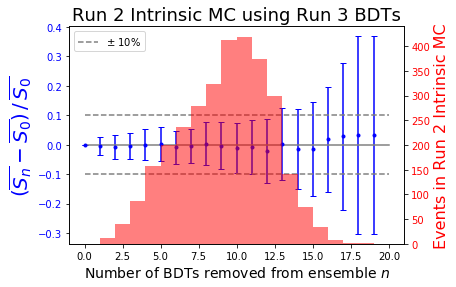

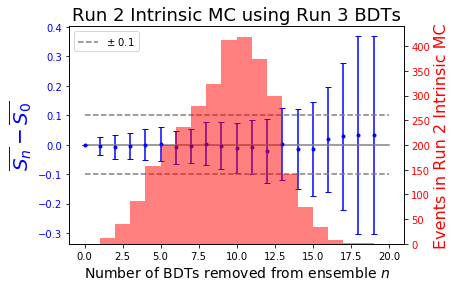

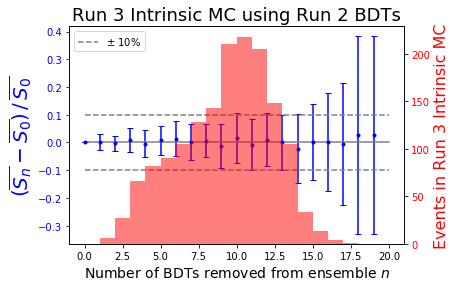

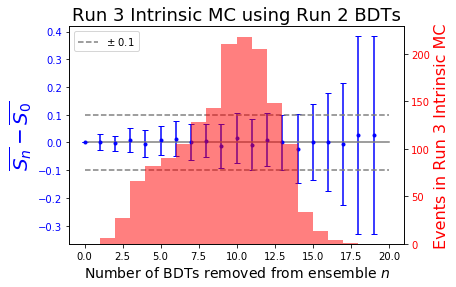

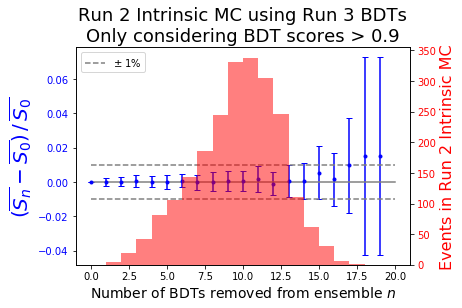

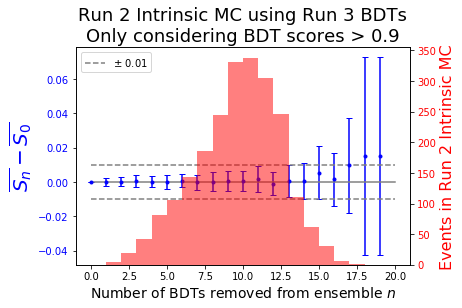

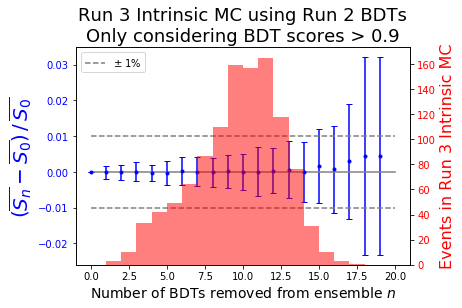

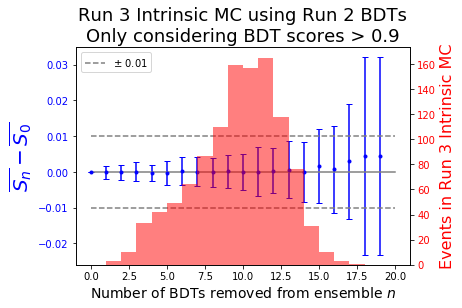

In [4]:
nBDTs = 20
for r in [2,3]:
    dfc = df_swap[r]['intrinsics'].copy()
    dfc_true = df[r]['intrinsics'].copy()
    bdtscores = {}
    numDropped = np.zeros(len(dfc_true))
    for k in range(20):
        MakeBDTcut(dfc,0,'avgscore',nBDTs,(r==2 and filetag=='overlay'),ttc=0.1,nDrop=k)
        bdtscores[k] = dfc['sigprob']
        numDropped += (dfc_true['tvweight%i'%k] < 1e-3)
    
    fracdifs = {}
    fracerrs = {}
    difs = {}
    errs = {}
    for k in range(20):
        arr = (bdtscores[k]-bdtscores[0])/(bdtscores[0]+1e-6)
        arr2 = (bdtscores[k]-bdtscores[0])
        fracdifs[k] = np.average(arr)
        fracerrs[k] = np.std(arr)
        difs[k] = np.average(arr2)
        errs[k] = np.std(arr2)
        
    fig,ax1 = plt.subplots()
    plt.title('Run %i Intrinsic MC using Run %i BDTs'%(r,2 if r==3 else 3),fontsize=18)
    plt.xlabel(r'Number of BDTs removed from ensemble $n$',fontsize=14)
    plt.ylabel(r'$(\overline{S_n} - \overline{S_0})\,/\,\overline{S_0}$',fontsize=20,color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Events in Run %i Intrinsic MC'%r,color='red',fontsize=16)
    ax2.hist(numDropped,bins=19,range=(1,20),alpha=0.5,color='red')
    ax2.tick_params(axis='y', labelcolor='red') 
    ax1.errorbar(fracdifs.keys(),fracdifs.values(),yerr=fracerrs.values(),fmt='.',capsize=3,color='blue')
    ax1.plot([0,20],[0,0],color='gray')
    ax1.plot([0,20],[0.1,0.1],color='gray',linestyle='--',label=r'$\pm$ 10%')
    ax1.plot([0,20],[-0.1,-0.1],color='gray',linestyle='--')
    ax1.legend()
    plt.show()
    
    fig,ax1 = plt.subplots()
    plt.title('Run %i Intrinsic MC using Run %i BDTs'%(r,2 if r==3 else 3),fontsize=18)
    plt.xlabel(r'Number of BDTs removed from ensemble $n$',fontsize=14)
    ax1.set_ylabel(r'$\overline{S_n} - \overline{S_0}$',fontsize=20,color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Events in Run %i Intrinsic MC'%r,color='red',fontsize=16)
    ax2.hist(numDropped,bins=19,range=(1,20),alpha=0.5,color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax1.errorbar(fracdifs.keys(),fracdifs.values(),yerr=fracerrs.values(),fmt='.',capsize=3,color='blue')
    ax1.plot([0,20],[0,0],color='gray')
    ax1.plot([0,20],[0.1,0.1],color='gray',linestyle='--',label=r'$\pm$ 0.1')
    ax1.plot([0,20],[-0.1,-0.1],color='gray',linestyle='--')
    ax1.legend()
    plt.show()
    
    
for r in [2,3]:
    dfc = df_swap[r]['intrinsics'].copy()
    dfc_true = df[r]['intrinsics'].copy()
    MakeBDTcut(dfc_true,0.9,'avgscore',nBDTs,(r==2 and filetag=='overlay'),ttc=0.1)
    dfc_true = dfc_true.query('bdtweight>0')
    bdtscores = {}
    numDropped = np.zeros(len(dfc_true))
    for k in range(20):
        MakeBDTcut(dfc,0,'avgscore',nBDTs,(r==2 and filetag=='overlay'),ttc=0.1,nDrop=k)
        bdtscores[k] = dfc['sigprob']
        numDropped += (dfc_true['tvweight%i'%k] < 1e-3)
    
    fracdifs = {}
    fracerrs = {}
    difs = {}
    errs = {}
    for k in range(20):
        arr = (bdtscores[k]-bdtscores[0])/(bdtscores[0]+1e-6)
        arr = arr[bdtscores[k] > 0.9]
        arr2 = (bdtscores[k]-bdtscores[0])
        arr2 = arr[bdtscores[k] > 0.9]
        fracdifs[k] = np.average(arr)
        fracerrs[k] = np.std(arr)
        difs[k] = np.average(arr2)
        errs[k] = np.std(arr2)
        
    fig,ax1 = plt.subplots()
    plt.title('Run %i Intrinsic MC using Run %i BDTs\nOnly considering BDT scores > 0.9'%(r,2 if r==3 else 3),fontsize=18)
    plt.xlabel(r'Number of BDTs removed from ensemble $n$',fontsize=14)
    ax1.set_ylabel(r'$(\overline{S_n} - \overline{S_0})\,/\,\overline{S_0}$',fontsize=20,color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Events in Run %i Intrinsic MC'%r,color='red',fontsize=16)
    ax2.hist(numDropped,bins=19,range=(1,20),alpha=0.5,color='red')
    ax2.tick_params(axis='y', labelcolor='red') 
    ax1.errorbar(fracdifs.keys(),fracdifs.values(),yerr=fracerrs.values(),fmt='.',capsize=3,color='blue')
    ax1.plot([0,20],[0,0],color='gray')
    ax1.plot([0,20],[0.01,0.01],color='gray',linestyle='--',label=r'$\pm$ 1%')
    ax1.plot([0,20],[-0.01,-0.01],color='gray',linestyle='--')
    ax1.legend()
    plt.show()
    
    fig,ax1 = plt.subplots()
    plt.title('Run %i Intrinsic MC using Run %i BDTs\nOnly considering BDT scores > 0.9'%(r,2 if r==3 else 3),fontsize=18)
    plt.xlabel(r'Number of BDTs removed from ensemble $n$',fontsize=14)
    ax1.set_ylabel(r'$\overline{S_n} - \overline{S_0}$',fontsize=20,color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Events in Run %i Intrinsic MC'%r,color='red',fontsize=16)
    ax2.hist(numDropped,bins=19,range=(1,20),alpha=0.5,color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax1.errorbar(fracdifs.keys(),fracdifs.values(),yerr=fracerrs.values(),fmt='.',capsize=3,color='blue')
    ax1.plot([0,20],[0,0],color='gray')
    ax1.plot([0,20],[0.01,0.01],color='gray',linestyle='--',label=r'$\pm$ 0.01')
    ax1.plot([0,20],[-0.01,-0.01],color='gray',linestyle='--')
    ax1.legend()
    plt.show()
    
    


[ 341.48812406 1019.6836187   591.99664804 ...  325.0854793   693.57864727
 1740.32419677]


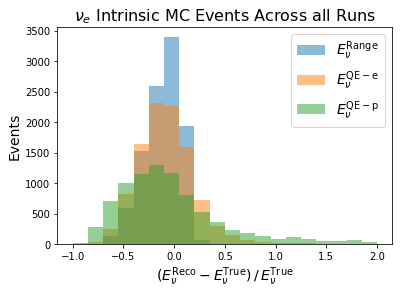

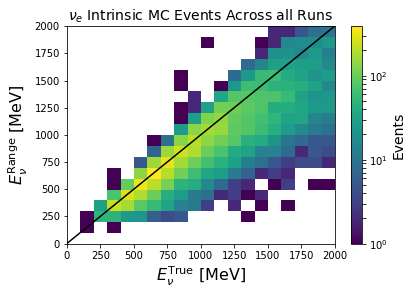

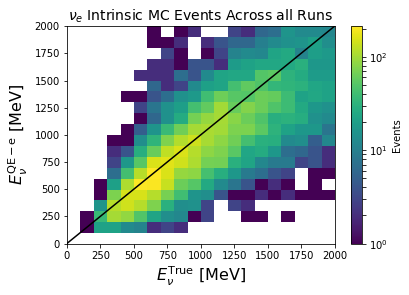

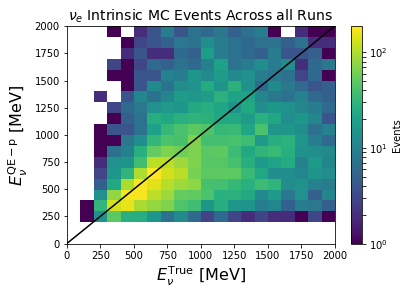

In [5]:
EnuRange = []
EnuQEe = []
EnuQEp = []
EnuTrue = []
filetag = 'intrinsics'
for r in [1,2,3]:
    dfc = df[r][filetag].copy()
    MakeBDTcut(dfc,0,'avgscore',nBDTs,(r==2 and filetag=='overlay'),ttc=0.1)
    dfc = dfc.query('sigprob>0.95')
    EnuRange += (list(dfc['Enu_1e1p']))
    EnuQEe += (list(dfc['EnuQE_lepton']))
    EnuQEp += (list(dfc['EnuQE_proton']))
    EnuTrue += (list(dfc['EnuTrue']))

EnuRange = np.array(EnuRange)
EnuQEe = np.array(EnuQEe)
EnuQEp = np.array(EnuQEp)
EnuTrue = np.array(EnuTrue)

print(EnuRange)

fracerr_range = (EnuRange - EnuTrue)/EnuTrue
fracerr_lep = (EnuQEe - EnuTrue)/EnuTrue
fracerr_proton = (EnuQEp - EnuTrue)/EnuTrue

plt.hist(fracerr_range,alpha=0.5,range=(-1,2),bins=20,label=r'$E_\nu^{\rm Range}$')
plt.hist(fracerr_lep,alpha=0.5,range=(-1,2),bins=20,label=r'$E_\nu^{\rm QE-e}$')
plt.hist(fracerr_proton,alpha=0.5,range=(-1,2),bins=20,label=r'$E_\nu^{\rm QE-p}$')
plt.legend(fontsize=14)
plt.xlabel(r'$(E_\nu^{\rm Reco} - E_\nu^{\rm True})\,/\,E_\nu^{\rm True}$',fontsize=14)
plt.ylabel('Events',fontsize=14)
plt.title(r'$\nu_e$ Intrinsic MC Events Across all Runs',fontsize=16)
plt.show()

plt.hist2d(EnuTrue,EnuRange,range=((0,2000),(0,2000)),bins=20,norm=LogNorm())
cb = plt.colorbar(label='Events')
cb.set_label(label='Events',fontsize=14)
plt.xlabel(r'$E_\nu^{\rm True}$ [MeV]',fontsize = 16)
plt.ylabel(r'$E_\nu^{\rm Range}$ [MeV]',fontsize = 16)
plt.plot([0,2000],[0,2000],color='black')
plt.title(r'$\nu_e$ Intrinsic MC Events Across all Runs',fontsize=14)
plt.show()

plt.hist2d(EnuTrue,EnuQEe,range=((0,2000),(0,2000)),bins=20,norm=LogNorm())
plt.colorbar(label='Events')
cb.set_label(label='Events',fontsize=14)
plt.xlabel(r'$E_\nu^{\rm True}$ [MeV]',fontsize = 16)
plt.ylabel(r'$E_\nu^{\rm QE-e}$ [MeV]',fontsize = 16)
plt.plot([0,2000],[0,2000],color='black')
plt.title(r'$\nu_e$ Intrinsic MC Events Across all Runs',fontsize=14)
plt.show()

plt.hist2d(EnuTrue,EnuQEp,range=((0,2000),(0,2000)),bins=20,norm=LogNorm())
plt.colorbar(label='Events')
cb.set_label(label='Events',fontsize=14)
plt.xlabel(r'$E_\nu^{\rm True}$ [MeV]',fontsize = 16)
plt.ylabel(r'$E_\nu^{\rm QE-p}$ [MeV]',fontsize = 16)
plt.plot([0,2000],[0,2000],color='black')
plt.title(r'$\nu_e$ Intrinsic MC Events Across all Runs',fontsize=14)
plt.show()


In [7]:
pi0full = pd.DataFrame()
pi0lim = pd.DataFrame()
for run in [1,2,3]:
    for tag in ['bnb_overlay','CCPi0','NCPi0']:
        try:
            pi0temp_full = pd.read_csv('../aux/pi0_landaufit_test/2021May31_fullpi0selection_%s_run%i.txt'%(tag,run),delimiter=',')
            pi0temp_full['run'] = [np.array(pi0temp_full['[run'])[i][1:] for i in range(len(pi0temp_full))]
            pi0temp_full['Enu'] = [np.array(pi0temp_full[' reco Enu]'])[i][:-1] for i in range(len(pi0temp_full))]
            pi0full = pd.concat((pi0full,pi0temp_full))
            
            pi0temp_lim = pd.read_csv('../aux/pi0_landaufit_test/2021May31_limitedpi0selection_%s_run%i.txt'%(tag,run),delimiter=',')
            pi0temp_lim['run'] = [np.array(pi0temp_lim['[run'])[i][1:] for i in range(len(pi0temp_lim))]
            pi0temp_lim['Enu'] = [np.array(pi0temp_lim[' reco Enu]'])[i][:-1] for i in range(len(pi0temp_lim))]
            pi0lim = pd.concat((pi0lim,pi0temp_lim))
        except:
            pass
        
        
        
        

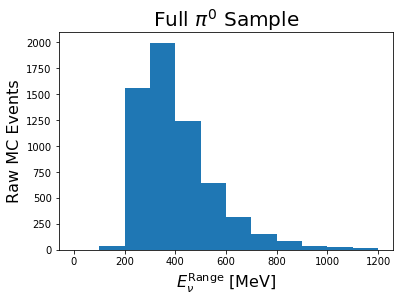

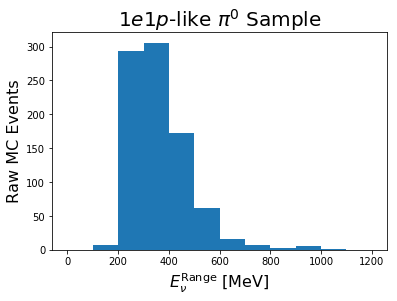

In [49]:
pf,x,_ = plt.hist(np.array(pi0full['Enu'],dtype=float),range=(0,1200),bins=12)
plt.xlabel(r'$E_\nu^{\rm Range}$ [MeV]',fontsize=16)
plt.ylabel('Raw MC Events',fontsize=16)
plt.title(r'Full $\pi^0$ Sample',fontsize=20)
plt.show()

pl,x,_ = plt.hist(np.array(pi0lim['Enu'],dtype=float),range=(0,1200),bins=12)
plt.xlabel(r'$E_\nu^{\rm Range}$ [MeV]',fontsize=16)
plt.ylabel('Raw MC Events',fontsize=16)
plt.title(r'$1e1p$-like $\pi^0$ Sample',fontsize=20)
plt.show()

pf = pf[2:]
pl = pl[2:]
x = x[2:]
xc = 0.5*(x[1:] + x[:-1])

In [50]:
# Fit to overall bkg rate
from lmfit import minimize, Parameters, report_fit
import scipy

def fitcdf(xlow, xhigh, cen, s):
    cdf = scipy.stats.moyal.cdf(xhigh,loc=cen,scale=s) - scipy.stats.moyal.cdf(xlow,loc=cen,scale=s)
    return  cdf

def fitfunc_dataset(params, xlow, xhigh):
    # calc fitfunc from params for data set i
    # using simple, hardwired naming convention

    cen  = params['cen'].value
    s    = params['s'].value
            
    return fitcdf(xlow, xhigh, cen, s)
    

def objective(params, xlow, xhigh, data):

    d = data
    e = np.sqrt(d)
    e = np.where(e==0,1,e)
    xl,xh = xlow,xhigh
    f = fitfunc_dataset(params, xl, xh)
    f *= sum(d)/sum(f)
    res = np.array((d - f) / e)
    return res

def fit(data,x):
    
    fit_params = Parameters()
    fit_params.add( 'cen', value=200, min=0,  max=500)
    fit_params.add( 's', value=100, min=0.0, max=200.0)

    # run the global fit to all the data sets
    result = minimize(objective, fit_params, args=(x[1:],x[:-1], data))
    report_fit(result)
    return result

In [51]:
result_full = fit(pf,x)
result_lim = fit(pl,x)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 23
    # data points      = 10
    # variables        = 2
    chi-square         = 2.86503690
    reduced chi-square = 0.35812961
    Akaike info crit   = -8.50003862
    Bayesian info crit = -7.89486844
[[Variables]]
    cen:  311.583608 +/- 1.25730913 (0.40%) (init = 200)
    s:    69.6316070 +/- 0.65217362 (0.94%) (init = 100)
[[Correlations]] (unreported correlations are < 0.100)
    C(cen, s) = -0.331
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 10
    # variables        = 2
    chi-square         = 11.2495376
    reduced chi-square = 1.40619220
    Akaike info crit   = 5.17741930
    Bayesian info crit = 5.78258948
[[Variables]]
    cen:  293.335142 +/- 4.83422551 (1.65%) (init = 200)
    s:    51.4436191 +/- 2.45885475 (4.78%) (init = 100)
[[Correlations]] (unreported correlations are < 0.100)
    C(cen, s) = -0.341


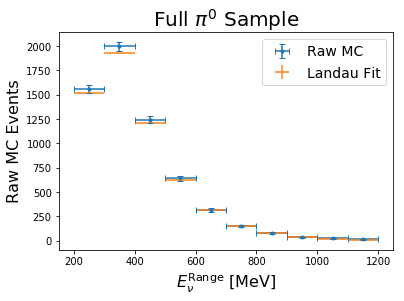

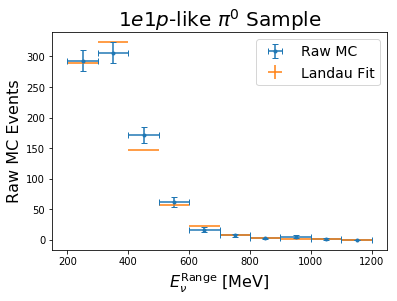

In [52]:
xft = np.arange(200,1200,1)

plt.errorbar(xc,pf,xerr=0.5*(x[1:]-x[:-1]),yerr=np.sqrt(pf),fmt='.',capsize=3,label='Raw MC')
plt.errorbar(xc,sum(pf)*fitfunc_dataset(result_full.params,x[:-1],x[1:]),xerr=0.5*(x[1:]-x[:-1]),yerr=0,fmt='.',markersize=0,label='Landau Fit')
plt.xlabel(r'$E_\nu^{\rm Range}$ [MeV]',fontsize=16)
plt.ylabel('Raw MC Events',fontsize=16)
plt.title(r'Full $\pi^0$ Sample',fontsize=20)
plt.legend(fontsize=14)
plt.show()

plt.errorbar(xc,pl,xerr=0.5*(x[1:]-x[:-1]),yerr=np.sqrt(pl),fmt='.',capsize=3,label='Raw MC')
plt.errorbar(xc,sum(pl)*fitfunc_dataset(result_lim.params,x[:-1],x[1:]),xerr=0.5*(x[1:]-x[:-1]),yerr=0,fmt='.',markersize=0,label='Landau Fit')
plt.xlabel(r'$E_\nu^{\rm Range}$ [MeV]',fontsize=16)
plt.ylabel('Raw MC Events',fontsize=16)
plt.title(r'$1e1p$-like $\pi^0$ Sample',fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Sam's Follow Up 2A

In [2]:
rsevlist =   [[ 7054,   778, 38917, 0],
             [ 7023,  1658, 82915, 0],
             [ 7023,   123,  6164, 0],
             [ 7013,     8,   440, 0],
             [ 7010,  1036, 51849, 0],
             [ 7010,   509, 25498, 0],
             [ 7008,  1411, 70569, 0],
             [12566,   244, 12202, 0],
             [11238,    49,  2497, 0],
             [10796,   198,  9950, 0],
             [ 8406,    63,  3194, 0],
             [16920,     9,   467, 0],
             [15491,   330, 16504, 0]]

wlist = [[4.16697600e-02],
         [2.82114158e-02],
         [2.45859160e-02],
         [3.39634097e-02],
         [4.07387525e-02],
         [3.47860770e-02],
         [3.96588299e-02],
         [1.83993554e-01],
         [2.79302407e-05],
         [1.40384741e-01],
         [1.69164811e-01],
         [4.73652592e-02],
         [3.39869953e-02]]

from ROOT import TFile
from root_pandas import read_root

# ---------------- Run 1 -------------- #

inExt1      = TFile.Open("/home/nwkamp/Research/MicroBooNE/Data/mcc9_v28_wctagger_extbnb_finalbdt.root")
inOvr1      = TFile.Open("/home/nwkamp/Research/MicroBooNE/Data/run1_overlay_stripmine.root")
inNue1      = TFile.Open("/home/nwkamp/Research/MicroBooNE/Data/run1_intrinsics_rerun_stripmine.root")
inNueLow1   = TFile.Open("/home/nwkamp/Research/MicroBooNE/Data/mcc9_v29e_run1_bnb_intrinsic_nue_overlay_LowE.root")
inNumuLow1  = TFile.Open("/home/nwkamp/Research/MicroBooNE/Data/mcc9_v29e_run1_bnb_nu_overlay_LowE.root")
inNCPi01    = TFile.Open("/home/nwkamp/Research/MicroBooNE/Data/mcc9_v40_NCPi0_run1_dlana_stripped_v2.root")
inCCPi01    = TFile.Open("/home/nwkamp/Research/MicroBooNE/Data/mcc9_v40_CCPi0_run1_dlana_stripped_v2.root")    
    

inExtFF1    = inExt1.Get("dlana/FinalVertexVariables")
inOvrFF1    = inOvr1.Get("FinalVertexVariables")
inNueFF1    = inNue1.Get("FinalVertexVariables")
inNueLowFF1 = inNueLow1.Get("dlana/FinalVertexVariables")
inNumuLowFF1= inNumuLow1.Get("dlana/FinalVertexVariables")
inCCPi0FF1    = inCCPi01.Get("dlana/FinalVertexVariables")
inNCPi0FF1    = inNCPi01.Get("dlana/FinalVertexVariables")

#inDirtFF   = inDirt.Get("dlana/FinalVertexVariables") 



# ---------------- Run 2 -------------- #

inOvr2      = TFile.Open("/home/nwkamp/Research/MicroBooNE/Data/run2_overlay_stripmine.root")
inNue2      = TFile.Open("/home/nwkamp/Research/MicroBooNE/Data/mcc9_v29e_dl_run2_bnb_intrinsics_nue_overlay_finalbdt.root")
inNueLow2   = TFile.Open("/home/nwkamp/Research/MicroBooNE/Data/mcc9_intrinsic_nue_lowe_run2_fvv_stripped.root")
inNumuLow2  = TFile.Open("/home/nwkamp/Research/MicroBooNE/Data/mcc9_bnb_overlay_lowe_run2_fvv_stripped.root")
    

inOvrFF2    = inOvr2.Get("FinalVertexVariables")
inNueFF2    = inNue2.Get("dlana/FinalVertexVariables")
inNueLowFF2 = inNueLow2.Get("dlana/FinalVertexVariables")
inNumuLowFF2= inNumuLow2.Get("dlana/FinalVertexVariables")




# ---------------- Run 3 -------------- #

inExt3      = TFile.Open("/home/nwkamp/Research/MicroBooNE/Data/mcc9_v29e_dl_run3_G1_extbnb_finalbdt.root")
inOvr3      = TFile.Open("/home/nwkamp/Research/MicroBooNE/Data/mcc9_v29e_dl_run3b_bnb_nu_overlay_nocrtremerge_finalbdt.root")
inNue3      = TFile.Open("/home/nwkamp/Research/MicroBooNE/Data/mcc9_v29e_dl_run3b_bnb_intrinsic_nue_overlay_nocrtremerge_finalbdt.root")
inNueLow3   = TFile.Open("/home/nwkamp/Research/MicroBooNE/Data/mcc9_v29e_dl_run3b_intrinsic_nue_LowE.root")
inNumuLow3  = TFile.Open("/home/nwkamp/Research/MicroBooNE/Data/mcc9_v29e_run3b_bnb_nu_overlay_LowE.root")
inNCPi03    = TFile.Open("/home/nwkamp/Research/MicroBooNE/Data/mcc9_v40_NCPi0_run3_dlana_stripped_v2.root")
inCCPi03    = TFile.Open("/home/nwkamp/Research/MicroBooNE/Data/mcc9_v40_CCPi0_run3_dlana_stripped_v2.root")
    
           
inExtFF3    = inExt3.Get("dlana/FinalVertexVariables")
inOvrFF3    = inOvr3.Get("dlana/FinalVertexVariables")
inNueFF3    = inNue3.Get("dlana/FinalVertexVariables")
inNueLowFF3 = inNueLow3.Get("dlana/FinalVertexVariables")
inNumuLowFF3 = inNumuLow3.Get("dlana/FinalVertexVariables")
inCCPi0FF3    = inCCPi03.Get("dlana/FinalVertexVariables")
inNCPi0FF3    = inNCPi03.Get("dlana/FinalVertexVariables")

tlist = {1:[inNCPi0FF1],
         2:[inOvrFF2],
         3:[inNCPi0FF3]}
    

Welcome to JupyROOT 6.16/00


In [48]:
for run in [1,2,3]:
    for i,t in enumerate(tlist[run]):
        for x in t:
            if [x.run,x.subrun,x.event,x.vtxid] in rsevlist and x.ccnc:
                data = [x.run,x.subrun,x.event,x.vtxid,
                        x.MC_nlepton,x.MC_nproton,x.npi0,
                        '%3.3f'%wlist[rsevlist.index([x.run,x.subrun,x.event,x.vtxid])][0]]
                for j,dat in enumerate(data):
                    if j!=len(data)-1: print(dat,end=' & ')
                    else: print(dat,end=' ')
                print('\\\\')
                print('\\hline')

7010 & 1036 & 51849 & 0 & 0 & 1 & 1 & 0.041 \\
\hline
7023 & 123 & 6164 & 0 & 0 & 1 & 1 & 0.025 \\
\hline
7008 & 1411 & 70569 & 0 & 0 & 1 & 1 & 0.040 \\
\hline
7013 & 8 & 440 & 0 & 0 & 1 & 1 & 0.034 \\
\hline
7054 & 778 & 38917 & 0 & 0 & 1 & 1 & 0.042 \\
\hline
7010 & 509 & 25498 & 0 & 0 & 1 & 1 & 0.035 \\
\hline
7023 & 1658 & 82915 & 0 & 0 & 1 & 1 & 0.028 \\
\hline
10796 & 198 & 9950 & 0 & 0 & 1 & 1 & 0.140 \\
\hline
12566 & 244 & 12202 & 0 & 0 & 1 & 1 & 0.184 \\
\hline
11238 & 49 & 2497 & 0 & 0 & 1 & 1 & 0.000 \\
\hline
8406 & 63 & 3194 & 0 & 0 & 2 & 1 & 0.169 \\
\hline
16920 & 9 & 467 & 0 & 0 & 1 & 1 & 0.047 \\
\hline
15491 & 330 & 16504 & 0 & 0 & 3 & 1 & 0.034 \\
\hline


# run 2 idx test

In [18]:
test1 = pd.read_csv('TextFiles/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/FinalSelection/avgscore/eventlist_overlay_fset0_run2.txt',delimiter=' ')
test2 = pd.read_csv('TextFiles/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/FinalSelection/avgscore/eventlist_overlay_run2.txt',delimiter=' ')



print(test1.query('sigprob > 0.95')[['run','subrun','event','EnuTrue','GenieWeight']])
print(test2.query('sigprob > 0.95')[['run','subrun','event','EnuTrue','GenieWeight']])




        run  subrun  event      EnuTrue  GenieWeight
224   12566     244  12202  1288.401001     0.904575
1059  11238      49   2497  3134.539551     0.000137
1272  10796     198   9950  1852.587280     0.690179
3423   9384      70   3535  1288.545776     1.000000
3433   9377      56   2813  3202.868164     0.806455
4156   8977     146   7314  1636.410645     1.272751
4431   8804     145   7271   971.393616     0.423723
5069   8406      63   3194   798.058716     0.831672
        run  subrun  event      EnuTrue  GenieWeight
224   12566     244  12202  1288.401001     0.904575
1059  11238      49   2497  3134.539551     0.000137
1272  10796     198   9950  1852.587280     0.690179
3423   9384      70   3535  1288.545776     1.000000
3433   9377      56   2813  3202.868164     0.806455
4156   8977     146   7314  1636.410645     1.272751
4431   8804     145   7271   971.393616     0.423723
5069   8406      63   3194   798.058716     0.831672


In [21]:
testdf = pd.read_parquet('Parquets/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/SelectionMode0_overlay_fset0_run3.parquet.gzip')


print(testdf.query('run==18044 and subrun==114 and event==5748'))

Empty DataFrame
Columns: [run, subrun, event, vtxid, Enu_1e1p, Eta, PT_1e1p, AlphaT_1e1p, SphB_1e1p, PzEnu_1e1p, ChargeNearTrunk, Q0_1e1p, Q3_1e1p, Thetas, Phis, PTRat_1e1p, Proton_ThetaReco, Proton_PhiReco, MinShrFrac, MaxShrFrac, BjXB_1e1p, BjYB_1e1p, Proton_Edep, Electron_Edep, Lepton_ThetaReco, Lepton_PhiReco, OpenAng, Xreco, Yreco, Zreco, MPIDY_muon, MPIDY_proton, MPIDY_eminus, shower_fraction, Shower_Consistency, EnuQE_lepton, EnuQE_proton, Proton_TrackLength, Lepton_TrackLength, EnuTrue, ccnc, interactionType, scedr, POTweight, GenieWeight, LEEweight, label, newpi0flag, oldpi0flag, datarun, filetag, cutLevel, nBDTs, tvweight0, sigprob0, tvweight1, sigprob1, tvweight2, sigprob2, tvweight3, sigprob3, tvweight4, sigprob4, tvweight5, sigprob5, tvweight6, sigprob6, tvweight7, sigprob7, tvweight8, sigprob8, tvweight9, sigprob9, tvweight10, sigprob10, tvweight11, sigprob11, tvweight12, sigprob12, tvweight13, sigprob13, tvweight14, sigprob14, tvweight15, sigprob15, tvweight16, sigprob16

In [24]:
testLocal = {}
testLocal[1] = pd.read_csv('TextFiles/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/FinalSelection/avgscore/eventlist_overlay_fset0_run1.txt',delimiter=' ')
testLocal[2] = pd.read_csv('TextFiles/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/FinalSelection/avgscore/eventlist_overlay_fset0_run2.txt',delimiter=' ')
testLocal[3] = pd.read_csv('TextFiles/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/FinalSelection/avgscore/eventlist_overlay_fset0_run3.txt',delimiter=' ')
testFNAL = {}
testFNAL[1] = pd.read_csv('TextFiles/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/FinalSelection/avgscore/onFNAL/eventlist_overlay_fset0_run1.txt',delimiter=' ')
testFNAL[2] = pd.read_csv('TextFiles/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/FinalSelection/avgscore/onFNAL/eventlist_overlay_fset0_run2.txt',delimiter=' ')
testFNAL[3] = pd.read_csv('TextFiles/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/FinalSelection/avgscore/onFNAL/eventlist_overlay_fset0_run3.txt',delimiter=' ')

for r in [1,2,3]:
    print(r)
    testBoth = testLocal[r].jo
    print(testLocal[r].query('sigprob > 0.7 and sigprob < 0.95')[['run','subrun','event','EnuTrue','GenieWeight']])
    print(testFNAL[r].query('sigprob > 0.7 and sigprob < 0.95')[['run','subrun','event','EnuTrue','GenieWeight']])

1
       run  subrun  event      EnuTrue  GenieWeight
202   7055      84   4242  1127.681030     0.431791
205   7055      21   1062   941.349670     1.383934
226   7054    1819  90960   496.644318     0.977715
311   7054    1178  58927   931.087036     0.702541
367   7054     726  36330   833.499023     0.757303
1129  7023     627  31365  1487.753296     0.639404
1438  7020    1218  60944   876.407593     0.162624
1533  7020     472  23630  1450.441284     1.228824
1546  7020     392  19628  1109.239380     0.653666
1898  7017     672  33618   998.066101     0.173028
2116  7014     752  37648  1452.839478     0.264675
2299  7012     908  45439  1398.905273     0.679504
2497  7010    1234  61703   569.366028     1.014311
2701  7008     989  49489  1846.266968     1.000000
3149  7004      38   1928  1168.905273     0.968653
3174  7003    1570  78549  1116.752930     1.000000
3234  7003    1085  54274   721.250854     1.124528
3611  6952     174   8714  1256.043823     1.000000
3878  6785

# run by run prediction comparison

In [36]:
run = {}
plot = {}
errs = {}
for i in [1,2,3]:
    run[i] = pd.read_csv('TextFiles/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/FinalSelection/avgscore/eventlist_intrinsics_fset0_run%i.txt'%i,delimiter=' ')
    plot[i],xb = np.histogram(run[i]['Enu_1e1p'],bins=12,range=(0,1200),weights=run[i]['GenieWeight'])
    errs[i] = np.sqrt(plot[i])
    norm = np.sum(plot[i])
    plot[i]/=norm
    errs[i]/=norm
    
xbc = 0.5*(xb[1:]+xb[:-1])
print(xbc)

[  50.  150.  250.  350.  450.  550.  650.  750.  850.  950. 1050. 1150.]


/home/nwkamp/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in divide
  
/home/nwkamp/.local/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys


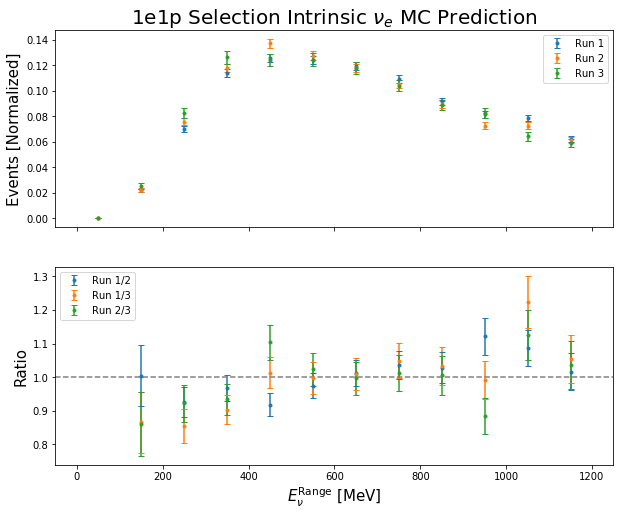

In [37]:
fig,ax = plt.subplots(2,figsize=(10,8),sharex=True)

for i in [1,2,3]: ax[0].errorbar(xbc,plot[i],yerr=errs[i],fmt='.',capsize=3,label='Run %i'%i)
for rs in [[1,2],[1,3],[2,3]]: 
    i,j = rs
    rat = plot[i]/plot[j]
    raterrs = rat * np.sqrt((errs[i]/plot[i])**2 + (errs[j]/plot[j])**2)
    ax[1].errorbar(xbc,rat,yerr=raterrs,fmt='.',capsize=3,label='Run %i/%i'%(i,j))

ax[1].plot([-50,1250],[1.0,1.0],color='grey',linestyle='--')
ax[1].set_xlabel(r'$E_\nu^{\rm Range}$ [MeV]',fontsize=15)
ax[0].set_ylabel(r'Events [Normalized]',fontsize=15)
ax[1].set_ylabel(r'Ratio',fontsize=15)
ax[0].set_title(r'1e1p Selection Intrinsic $\nu_e$ MC Prediction',fontsize=20)
ax[0].legend()
ax[1].legend()
ax[0].set_xlim(-50,1250)
ax[1].set_xlim(-50,1250)
plt.show()